In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt

import importlib
importlib.reload(pt)

%load_ext autoreload
%autoreload 2


## Loading files

In [2]:
# PATHS
S2_stacked_1_raw = "../data/02_processed/S2_Stacked_Site_1.tif"
S2_stacked_2_raw = "../data/02_processed/S2_Stacked_Site_2.tif"

# rather take the normalized S2 stacks
# === INPUT Paths ===
S2_stacked_1 = "../data/02_processed/S2_Stacked_Site_1_norm.tif"
S2_stacked_2 = "../data/02_processed/S2_Stacked_Site_2_norm.tif"

ALS_PATH1_RES = "../data/02_processed/ALS_resampled_site1.tif"
ALS_PATH2_RES = "../data/02_processed/ALS_resampled_site2.tif"

# ALS_PATH1_RES_NORM = "../data/02_processed/ALS_norm_Site1_Ebrach.tif"
# ALS_PATH2_RES_NORM = "../data/02_processed/ALS_norm_Site2_Waldbrunn.tif"

# use the joint normalized ALS files:
ALS_PATH1_RES_NORM = "../data/02_processed/ALS_norm_Site1_Ebrach_joint.tif"
ALS_PATH2_RES_NORM = "../data/02_processed/ALS_norm_Site2_Waldbrunn_joint.tif"

FOREST_MASK1 = '../data/02_processed/fmask_01_Ebrach.tif' #ebrach
FOREST_MASK2 = '../data/02_processed/fmask_02_Waldbrunn.tif' #waldbrunn

# === OUTPUT Paths ===
OUTPUT_FOLDER = "../data/03_training"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

In [3]:
# Load S2 and merged ALS data for both sites and combine them in an array

s2_np, als_np, _ = bsc.load_rasters(S2_stacked_1, ALS_PATH1_RES_NORM,verbose=True,s2_channel="Q50")
s2_np2, als_np2, _ = bsc.load_rasters(S2_stacked_2, ALS_PATH2_RES_NORM,verbose=False,s2_channel="Q50")

fmask1 = bsc.read_tif_as_array(FOREST_MASK1, verbose=True)
fmask2 = bsc.read_tif_as_array(FOREST_MASK2, verbose=True)


✅ Loaded S2: (13, 846, 1241), ALS: (846, 1241)
S2_Stacked_Site_1_norm.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre
  Band names: ('BLU_Q50', 'BNR_Q50', 'EVI_Q50', 'GRN_Q50', 'NBR_Q50', 'NDV_Q50', 'NIR_Q50', 'RE1_Q50', 'RE2_Q50', 'RE3_Q50', 'RED_Q50', 'SW1_Q50', 'SW2_Q50')

ALS_norm_Site1_Ebrach_joint.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

✅ Loaded fmask_01_Ebrach.tif: shape=(846, 1241), CRS=EPSG:25832, GSD=10.00 x 10.00 metre
Band names: (None,)
✅ Loaded fmask_02_Waldbrunn.tif: shape=(1002, 815), CRS=EPSG:25832, GSD=10.00 x 10.00 metre
Band names: (None,)


In [4]:
# TO-DO: Fix nan count introduced by normalization
print("S2 Site 1 normalized NaN count:", np.isnan(s2_np).sum())
print("S2 Site 2 normalized NaN count:", np.isnan(s2_np2).sum())
print("S2 Site 1 normalized min:", np.nanmin(s2_np), "max:", np.nanmax(s2_np))
print("S2 Site 2 fmask NaN count:", np.isnan(fmask2).sum())


S2 Site 1 normalized NaN count: 1560
S2 Site 2 normalized NaN count: 1729
S2 Site 1 normalized min: 0.0 max: 1.0
S2 Site 2 fmask NaN count: 0


## Do Patch extraction

In [28]:
def extract_patches_with_resampled_data(s2, als, fmask, patch_size, only_full_patches=False,verbose=True):
    """
    Extract patches from S2 data and resampled ALS data.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als: numpy array of resampled ALS values (height, width)
    - fmask: numpy array of forest mask (height, width)
    - patch_size: size of the patches to extract
    - only_full_patches: if True, only return patches with no NaN/missing data

    Returns:
    - s2_patches: numpy array of S2 patches
    - als_patches: numpy array of ALS ground truth patches
    - combined_patches: numpy array of combined patches (S2 + ALS as additional band)
    """
    _, h, w = s2.shape
    patches_s2, patches_als, patches_fmask, combined_patches = [], [], [], []
    full_patch_count = 0

    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            s2_patch = s2[:, i:i+patch_size, j:j+patch_size]
            als_patch = als[i:i+patch_size, j:j+patch_size]
            fmask_patch = fmask[i:i+patch_size, j:j+patch_size]
            
            # To-Do: also append the forest mask patch
            combined_patch = np.concatenate(
                [s2_patch, als_patch[np.newaxis, :, :], fmask_patch[np.newaxis, :, :]], axis=0
            )

            has_nan = np.isnan(combined_patch).any()
            if not has_nan:
                full_patch_count += 1

            if only_full_patches and has_nan:
                continue

            patches_s2.append(s2_patch)
            patches_als.append(als_patch)
            patches_fmask.append(fmask_patch)
            combined_patches.append(combined_patch)

    s2_arr = np.stack(patches_s2) if patches_s2 else np.empty((0, s2.shape[0], patch_size, patch_size))
    als_arr = np.stack(patches_als) if patches_als else np.empty((0, patch_size, patch_size))
    fmask_arr = np.stack(patches_fmask) if patches_fmask else np.empty((0, patch_size, patch_size))
    combined_arr = np.stack(combined_patches) if combined_patches else np.empty((0, s2.shape[0]+1, patch_size, patch_size))
    if verbose:
        print(f"Patch size: {patch_size}, Number of patches: {len(s2_arr)}, Full patches (no NaN): {full_patch_count}")
    return s2_arr, als_arr, fmask_arr, combined_arr


In [50]:
def extract_patches_withnanpc(s2, als, fmask, patch_size, nan_percent_allowed=0, verbose=True):
    """
    Extract patches from S2 data and resampled ALS data.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als: numpy array of resampled ALS values (height, width)
    - fmask: numpy array of forest mask (height, width)
    - patch_size: size of the patches to extract
    - nan_percent_allowed: float, percent (0-100) of NaN pixels allowed per patch

    Returns:
    - s2_patches: numpy array of S2 patches
    - als_patches: numpy array of ALS ground truth patches
    - fmask_patches: numpy array of forest mask patches
    - combined_patches: numpy array of combined patches (S2 + ALS + fmask as additional bands)
    """
    _, h, w = s2.shape
    patches_s2, patches_als, patches_fmask, combined_patches = [], [], [], []
    full_patch_count = 0

    allowed_nan_s2 = int((nan_percent_allowed / 100.0) * patch_size * patch_size * (s2.shape[0]+1)) #+1 for als
    allowed_nan_als = int((nan_percent_allowed / 100.0) * patch_size * patch_size ) # 1channel only

    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            s2_patch = s2[:, i:i+patch_size, j:j+patch_size]
            als_patch = als[i:i+patch_size, j:j+patch_size]
            fmask_patch = fmask[i:i+patch_size, j:j+patch_size]
            combined_patch = np.concatenate(
                [s2_patch, als_patch[np.newaxis, :, :], fmask_patch[np.newaxis, :, :]], axis=0
            )

            nan_count = np.isnan(combined_patch).sum()
            nan_s2 = np.isnan(s2_patch).sum()
            nan_als = np.isnan(als_patch).sum()
            if nan_count == 0:
                full_patch_count += 1

            if (nan_s2 > allowed_nan_s2) or (nan_als > allowed_nan_als):
                continue

            patches_s2.append(s2_patch)
            patches_als.append(als_patch)
            patches_fmask.append(fmask_patch)
            combined_patches.append(combined_patch)

    s2_arr = np.stack(patches_s2) if patches_s2 else np.empty((0, s2.shape[0], patch_size, patch_size))
    als_arr = np.stack(patches_als) if patches_als else np.empty((0, patch_size, patch_size))
    fmask_arr = np.stack(patches_fmask) if patches_fmask else np.empty((0, patch_size, patch_size))
    combined_arr = np.stack(combined_patches) if combined_patches else np.empty((0, s2.shape[0]+2, patch_size, patch_size))
    stats = [patch_size,len(s2_arr),nan_percent_allowed]
    if verbose:
        print(f"Patch size: {patch_size}, Number of patches: {len(s2_arr)}, Full patches (no NaN): {full_patch_count}, nan_percent_allowed: {nan_percent_allowed}%")
    return s2_arr, als_arr, fmask_arr, combined_arr, stats

In [51]:
patches = [16,32,64,128,256]
s2 = [s2_np, s2_np2]
als = [als_np, als_np2]
fmask = [fmask1, fmask2]
i = 0
for s2, als, fmask in zip(s2, als, fmask):
    i+= 1
    print(f"Processing site {i}...")
    print("---------------------")
    print(f"S2 shape: {s2.shape}, ALS shape: {als.shape}")
    for p in patches:
        #print(f"Extracting patches of size {p}...")
        #s2_arr, als_arr, fmask_arr, combined_arr = extract_patches_with_resampled_data(s2, als, fmask, p, only_full_patches=False)
        s2_arr, als_arr, fmask_arr, combined_arr, _ = extract_patches_withnanpc(s2, als, fmask, p, nan_percent_allowed=8, verbose=True)
        #print(f"Shape of Combined patches: {combined_arr.shape}, S2 patches: {s2_arr.shape}, ALS patches: {als_arr.shape}, Fmask patches: {fmask_arr.shape}")
    print("---------------------")

Processing site 1...
---------------------
S2 shape: (13, 846, 1241), ALS shape: (846, 1241)
Patch size: 16, Number of patches: 1844, Full patches (no NaN): 1678, nan_percent_allowed: 8%
Patch size: 32, Number of patches: 441, Full patches (no NaN): 360, nan_percent_allowed: 8%
Patch size: 64, Number of patches: 102, Full patches (no NaN): 65, nan_percent_allowed: 8%
Patch size: 128, Number of patches: 20, Full patches (no NaN): 9, nan_percent_allowed: 8%
Patch size: 256, Number of patches: 3, Full patches (no NaN): 0, nan_percent_allowed: 8%
---------------------
Processing site 2...
---------------------
S2 shape: (13, 1002, 815), ALS shape: (1002, 815)
Patch size: 16, Number of patches: 1611, Full patches (no NaN): 1479, nan_percent_allowed: 8%
Patch size: 32, Number of patches: 383, Full patches (no NaN): 313, nan_percent_allowed: 8%
Patch size: 64, Number of patches: 83, Full patches (no NaN): 52, nan_percent_allowed: 8%
Patch size: 128, Number of patches: 17, Full patches (no NaN

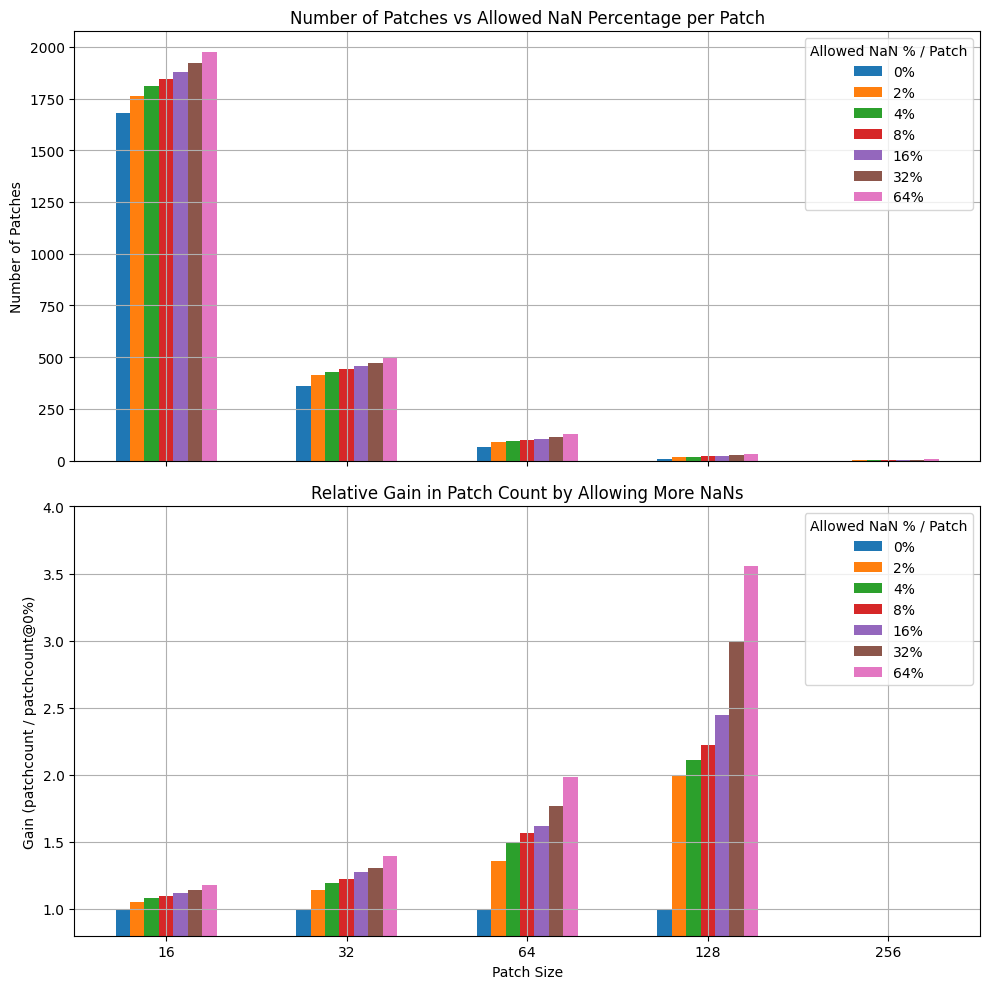

In [77]:
patches = [16, 32, 64, 128, 256]
nan_percents = [0, 2, 4, 8, 16, 32, 64]
s2 = [s2_np, s2_np2]
als = [als_np, als_np2]
fmask = [fmask1, fmask2]
results = []

for p in patches:
    for nan_pc in nan_percents:
        _, _, _, _, stats = extract_patches_withnanpc(s2_np, als_np, fmask1, p, nan_percent_allowed=nan_pc, verbose=False)
        # stats = [patch_size, num_patches, nan_percent_allowed]
        results.append(stats)

results = np.array(results)
# Reshape for plotting: rows=patch sizes, cols=nan_percents
num_patches_matrix = results[:, 1].reshape(len(patches), len(nan_percents))

# Calculate gain: ratio to the 0% NaN patch count for each patch size
gain = np.zeros_like(num_patches_matrix, dtype=float)
for i in range(len(patches)):
    base = num_patches_matrix[i, 0]
    if base == 0:
        gain[i, :] = 0
    else:
        gain[i, :] = num_patches_matrix[i, :] / base

bar_width = 0.08
x = np.arange(len(patches))

fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Top: original bar plot
for i, nan_pc in enumerate(nan_percents):
    ax1.bar(x + i * bar_width, num_patches_matrix[:, i], width=bar_width, label=f'{nan_pc:.0f}%')
ax1.set_xticks(x + bar_width * (len(nan_percents) - 1) / 2)
ax1.set_xticklabels([str(p) for p in patches])
ax1.set_ylabel('Number of Patches')
ax1.set_title('Number of Patches vs Allowed NaN Percentage per Patch')
ax1.legend(title='Allowed NaN % / Patch')
ax1.grid()

# Bottom: gain bar plot
for i, nan_pc in enumerate(nan_percents):
    ax2.bar(x + i * bar_width, gain[:, i], width=bar_width, label=f'{nan_pc:.0f}%')
ax2.set_xlabel('Patch Size')
ax2.set_ylabel('Gain (patchcount / patchcount@0%)')
ax2.set_title('Relative Gain in Patch Count by Allowing More NaNs')
ax2.legend(title='Allowed NaN % / Patch')
ax2.set_xticks(x + bar_width * (len(nan_percents) - 1) / 2)
ax2.set_xticklabels([str(p) for p in patches])
ax2.set_ylim(0.8,4)
ax2.grid()

plt.tight_layout()
plt.show()

#print(gain)

## save patches as numpy stacks

In [81]:
# write a function to save the patches as numpy arrays
def save_patches_as_npy_nantolerant(s2, als, fmask, output_folder, patch_size, site_number, nan_pc):
    """
    Save the extracted patches as numpy arrays.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als: numpy array of resampled ALS values (height, width)
    - patch_size: size of the patches to extract
    - site_number: site number (1 or 2)
    """
    s2_patches, als_patches, fmask_patches, combined_patches, _ = extract_patches_withnanpc(s2, als, fmask, patch_size, nan_percent_allowed=nan_pc, verbose=True)
    output_folder += '/32_withNaN'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    np.save(os.path.join(output_folder, f"S2_site{site_number}_px{patch_size}.npy"), s2_patches)
    np.save(os.path.join(output_folder, f"ALS_site{site_number}_px{patch_size}.npy"), als_patches)
    np.save(os.path.join(output_folder, f"FMASK_site{site_number}_px{patch_size}.npy"), fmask_patches)
    np.save(os.path.join(output_folder, f"S2_ALS_site{site_number}_px{patch_size}.npy"), combined_patches)

    print(f"Patches saved for site {site_number}, patch size {patch_size}, folder {output_folder}")

In [83]:
save_patches_as_npy_nantolerant(s2_np, als_np, fmask1, OUTPUT_FOLDER, 32, 1,nan_pc=8)
save_patches_as_npy_nantolerant(s2_np2, als_np2, fmask2, OUTPUT_FOLDER, 32, 2,nan_pc=8)

Patch size: 32, Number of patches: 441, Full patches (no NaN): 360, nan_percent_allowed: 8%
Patches saved for site 1, patch size 32, folder ../data/03_training/32_withNaN
Patch size: 32, Number of patches: 383, Full patches (no NaN): 313, nan_percent_allowed: 8%
Patches saved for site 2, patch size 32, folder ../data/03_training/32_withNaN


### former function, binary only non-nans

In [33]:
# write a function to save the patches as numpy arrays
def save_patches_as_npy(s2, als, fmask, output_folder, patch_size, site_number):
    """
    Save the extracted patches as numpy arrays.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als: numpy array of resampled ALS values (height, width)
    - patch_size: size of the patches to extract
    - site_number: site number (1 or 2)
    """
    s2_patches, als_patches, fmask_patches, combined_patches = extract_patches_with_resampled_data(s2, als, fmask, patch_size, only_full_patches=True, verbose=False)

    np.save(os.path.join(output_folder, f"S2_site{site_number}_px{patch_size}.npy"), s2_patches)
    np.save(os.path.join(output_folder, f"ALS_site{site_number}_px{patch_size}.npy"), als_patches)
    np.save(os.path.join(output_folder, f"FMASK_site{site_number}_px{patch_size}.npy"), fmask_patches)
    np.save(os.path.join(output_folder, f"S2_ALS_site{site_number}_px{patch_size}.npy"), combined_patches)

    print(f"Patches saved for site {site_number}, patch size {patch_size}.")

In [ ]:
if False:
    save_patches_as_npy(s2_np, als_np, fmask1, OUTPUT_FOLDER, 32, 1)
    save_patches_as_npy(s2_np2, als_np2, fmask2, OUTPUT_FOLDER, 32, 2)

Patches saved for site 1, patch size 32.
Patches saved for site 2, patch size 32.


## some intuitiuon plotting

Patch size: 32, Number of patches: 766, Full patches (no NaN): 313, nan_percent_allowed: 8%


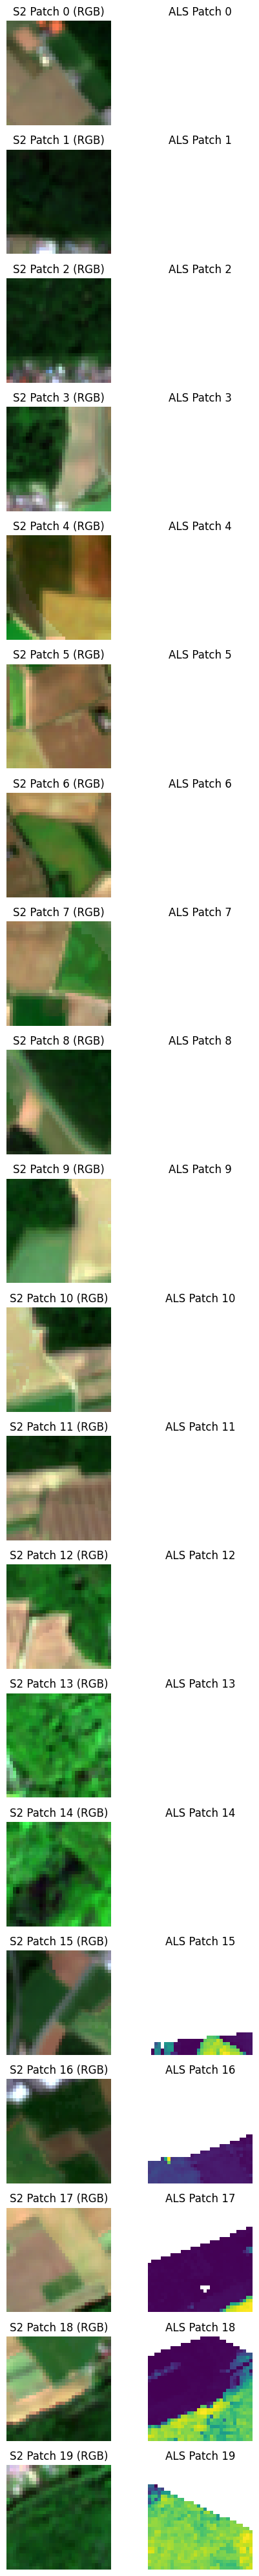

In [49]:
p = 32
s2 = s2_np2 #[s2_np, 
als = als_np2 #[als_np, als_np2]
#fmask = fmask2 #[fmask1, fmask2]

#s2_arr, als_arr, fmask_arr, combined_arr = extract_patches_with_resampled_data(s2, als, fmask2, p, only_full_patches=True)
s2_arr, als_arr, fmask_arr, combined_arr, _ = extract_patches_withnanpc(s2, als, fmask, p, nan_percent_allowed=8, verbose=True)

# plot some patches directly here
n_patches = 20
fig, axes = plt.subplots(n_patches, 2, figsize=(5, 2 * n_patches))

for idx in range(n_patches):
    # S2 RGB composite (bands 10, 3, 0 if available)
    if s2_arr.shape[1] >= 4:
        rgb = np.stack([
            s2_arr[idx, 10],  # band 10 (red)
            s2_arr[idx, 3],  # band 3 (green)
            s2_arr[idx, 0],  # band 0 (blue)
        ], axis=-1)
        #rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb) + 1e-6)
        # rgb is already normalized between 0 and 1, so maybe rgb plotting is too dark. adjusting it:
        rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb) + 1e-6)
        # Ensure RGB values are in the range [0, 1]
        
        #rgb = np.clip(rgb, 0, 1)
        #rgb = (rgb * 255)#.astype(np.uint16)
        axes[idx, 0].imshow(rgb)
        axes[idx, 0].set_title(f"S2 Patch {idx} (RGB)")
    else:
        axes[idx, 0].imshow(s2_arr[idx, 0], cmap='gray')
        axes[idx, 0].set_title(f"S2 Patch {idx} (Band 0)")

    # ALS patch
    axes[idx, 1].imshow(als_arr[idx], cmap='viridis')
    axes[idx, 1].set_title(f"ALS Patch {idx}")


    for j in range(2):
        axes[idx, j].axis('off')

plt.tight_layout()
plt.show()


In [12]:
def load_and_split_patches(site, patch_size=32, test_size=0.2, random_state=42):
    """
    Load S2 and ALS patches for a given site, split into train/test sets.

    Parameters:
    - site: int (1 or 2)
    - patch_size: int
    - test_size: float
    - random_state: int

    Returns:
    - X_train, X_test, y_train, y_test
    """
    s2_patches = np.load(os.path.join(OUTPUT_FOLDER, f"S2_site{site}_px{patch_size}.npy"))
    als_patches = np.load(os.path.join(OUTPUT_FOLDER, f"ALS_site{site}_px{patch_size}.npy"))
    X_train, X_test, y_train, y_test = train_test_split(
        s2_patches, als_patches, test_size=test_size, random_state=random_state
    )
    print(f"Site {site}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Site {site}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    return X_train, X_test, y_train, y_test

# Execute for site 1 and 2
X_train1, X_test1, y_train1, y_test1 = load_and_split_patches(site=1)
X_train2, X_test2, y_train2, y_test2 = load_and_split_patches(site=2)

Site 1: X_train shape: (288, 13, 32, 32), y_train shape: (288, 32, 32)
Site 1: X_test shape: (72, 13, 32, 32), y_test shape: (72, 32, 32)
Site 2: X_train shape: (253, 13, 32, 32), y_train shape: (253, 32, 32)
Site 2: X_test shape: (64, 13, 32, 32), y_test shape: (64, 32, 32)


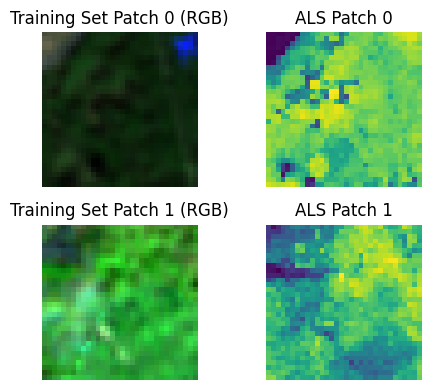

In [13]:
# Now we can visualize the training and test sets
def plot_patches(X, Y, title, n_patches=5):
    fig, axes = plt.subplots(n_patches, 2, figsize=(5, 2 * n_patches))
    for idx in range(n_patches):
        # S2 RGB composite (bands 10, 3, 0 if available)
        if X.shape[1] >= 4:
            rgb = np.stack([
                X[idx, 10],  # band 10 (red)
                X[idx, 3],   # band 3 (green)
                X[idx, 0],   # band 0 (blue)
            ], axis=-1)
            rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb) + 1e-6)
            axes[idx, 0].imshow(rgb)
            axes[idx, 0].set_title(f"{title} Patch {idx} (RGB)")
        else:
            axes[idx, 0].imshow(X[idx, 0], cmap='gray')
            axes[idx, 0].set_title(f"{title} Patch {idx} (Band 0)")

        # ALS patch
        axes[idx, 1].imshow(Y[idx], cmap='viridis')
        axes[idx, 1].set_title(f"ALS Patch {idx}")

        for j in range(2):
            axes[idx, j].axis('off')

    plt.tight_layout()
    plt.show()
# Plot the training patches
plot_patches(X_train2, y_train2, "Training Set", n_patches=2)
# Plot the test patches
#plot_patches(X_test, "Test Set", n_patches=5)

## lets have a look at the 3D surface of the ALS

In [14]:
# write a function that plots some 3D figure of the ALS data for some patches
def plot_als_3d_patches(als_patches, n_patches=5):
    """
    Plot 3D ALS patches.

    Parameters:
    - als_patches: numpy array of ALS patches (num_patches, height, width)
    - n_patches: number of patches to plot
    """
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 10))
    for idx in range(n_patches):
        ax = fig.add_subplot(n_patches, 1, idx + 1, projection='3d')
        als_patch = als_patches[idx]
        x = np.arange(als_patch.shape[1])
        y = np.arange(als_patch.shape[0])
        X, Y = np.meshgrid(x, y)
        ax.plot_surface(X, Y, als_patch, cmap='viridis')
        ax.set_title(f"ALS Patch {idx} (3D View)")
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        ax.set_zlabel('ALS Value')

    plt.tight_layout()
    plt.show()
# Plot 3D ALS patches for the first 5 patches of site 1


In [15]:
p=64
_, als_resp, _ = extract_patches_with_resampled_data(s2_np, als_np, p, only_full_patches=True)

Patch size: 64, Number of patches: 65, Full patches (no NaN): 65


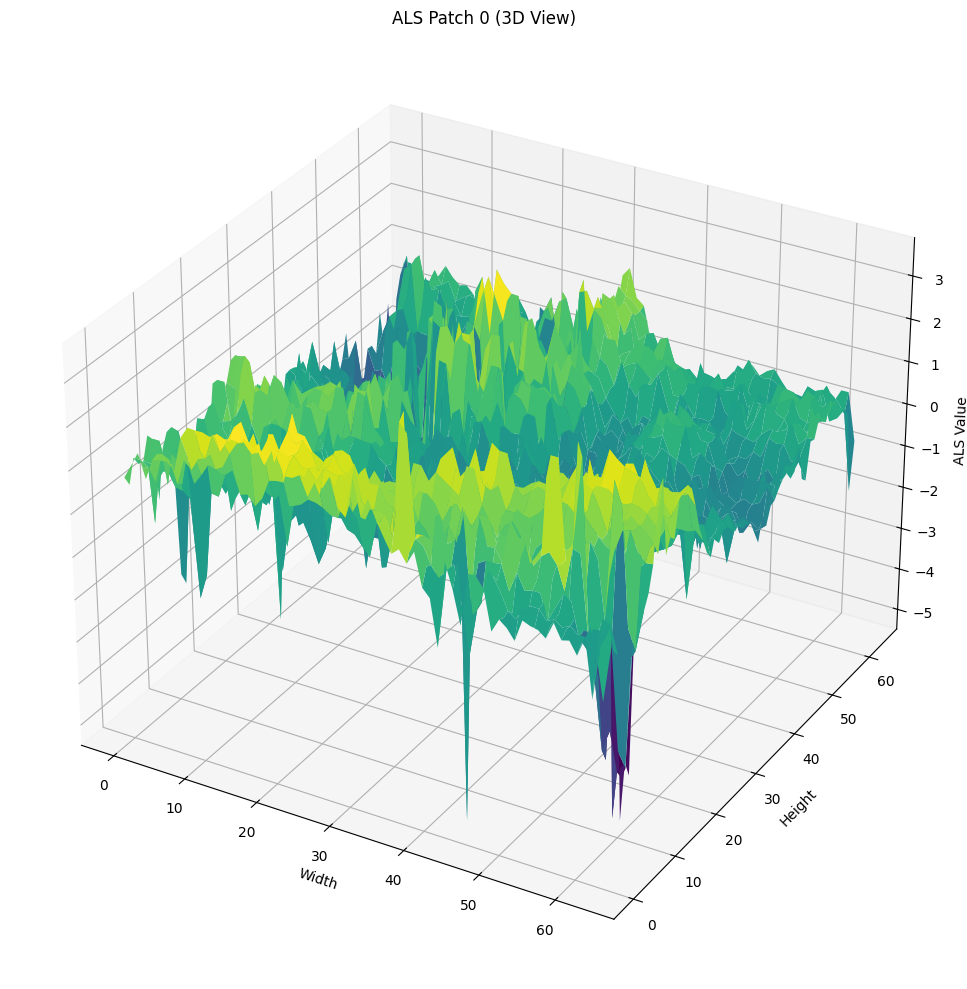

In [16]:
plot_als_3d_patches(als_resp[2:], n_patches=1)